# 9 - Synthetic Control Analysis
hsujulia
4april2022

Let's do some synthetic control using CPS data. 
This notebook is inspired by (https://github.com/matheusfacure/python-causality-handbook/blob/master/causal-inference-for-the-brave-and-true/15-Synthetic-Control.ipynb) 

We'll start with a synthetic control that only estimates weights based on the outcome. Then we will improve on this by incorporating covariate features.


In [2]:
import pandas as pd
import numpy as np
import os as os 

from matplotlib import gridspec
import matplotlib.pyplot as plt
%matplotlib inline  

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.discrete.conditional_models import ConditionalLogit

from IPython.display import display    


import scipy.stats 

from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso, Ridge, LassoCV, LogisticRegressionCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.metrics import mean_squared_error


In [3]:
os.getcwd()

'/Users/hsujulia/Documents/GitHub/causalinference_crashcourse/Notebooks'

In [4]:
df = pd.read_pickle('/Users/hsujulia/Documents/GitHub/causalinference_crashcourse/Notebooks/9 Synthetic Control - CPS Data')

## 1. Set up a fake treatment.
Let's pick NJ to be our placebo state, where our outcome is unemployment rate. Then we will use synthetic control of a pre-treatment period to figure out what the synthetic control would look like, then compare the actual and predicted outcome.

We'll start by plotting the unemployment rate over our dataset, then let's apply a fake treatment to the unemployment rate at a given time frame.

In [5]:
df = df.reset_index()

Text(0.5, 0.98, 'Unemployment Rate in 2021')

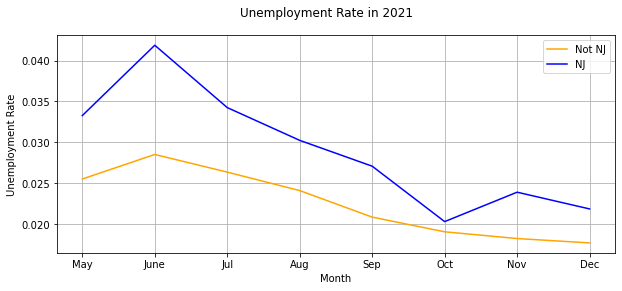

In [6]:
df['NJ_not'] = (df['state']=='NJ')
df_plot = df.groupby(['NJ_not','hryear4','hrmonth'])['laborforce_unemp'].mean().to_frame()
df_plot.reset_index(inplace=True)
fig,ax = plt.subplots(figsize=(10,4))
ax.plot( df_plot.loc[df_plot['NJ_not']==False]['hrmonth'], df_plot.loc[df_plot['NJ_not']==False]['laborforce_unemp'], 
            color='orange', label='Not NJ')
ax.plot( df_plot.loc[df_plot['NJ_not']==True]['hrmonth'], df_plot.loc[df_plot['NJ_not']==True]['laborforce_unemp'], 
        color='blue', label='NJ')
ax.set_ylabel('Unemployment Rate')
ax.set_xlabel('Month')
ax.set_xticks(np.arange(5,12.1,1))
ax.set_xticklabels(['May','June','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.grid()
ax.legend(loc='upper right')
fig.suptitle('Unemployment Rate in 2021')


Let's decide Nov-2021 as the treatment time, with Dec-2021 as when the treatment effect is observed.

In [7]:
df['treatment'] = (df['hrmonth'] >= 12)

In [8]:
features = [
       'hefaminc_0k_15k','hefaminc_15k_50k', 'hefaminc_50k_100k', 'hefaminc_100kplus',
#        'laborforce_no', 'laborforce_unemp', 'laborforce_ft', 'laborforce_pt',
       'marriage', 'rent', 'agri', 'educ_lesshs', 'educ_someAA', 'educ_BA',
       'educ_grad', 'prernwa']


In [9]:
####
## Do some feature selection of the outcome
####
lcv = LassoCV(cv=5, normalize=True)
lcv_fit = lcv.fit(y=df['laborforce_employed'],X=df[features[1:]])
selected_features = []
for f,p in zip(features[1:],lcv_fit.coef_):
    if p !=0:
        print('{0} {1:10.7f}'.format(f,p))
        selected_features.append(f)
    

hefaminc_15k_50k  0.1507036
hefaminc_50k_100k  0.2700561
hefaminc_100kplus  0.1698928
marriage  0.0338663
agri  0.9952903
educ_lesshs -0.2363124
educ_someAA -0.0693964
educ_BA  0.1921779
educ_grad -0.1708637
prernwa  0.0000069


## 2. Only using the outcome variable
This is relatively simple in that we only need to calculate weights to match the pre-treatment period outcome. However, the risk is that the synthetic controls may be different in key features that relate to our outcome. We'll try to address this in the next section. This Section serves as a baseline for comparison.

In [10]:
## Now bring in functions needed to calculate weights for synthetic control

from typing import List
from operator import add
from toolz import reduce, partial

## Define loss function
def loss_w(W, X, y) -> float:
    return np.sqrt(np.mean((y - X.dot(W))**2))

from scipy.optimize import fmin_slsqp

def get_w(X, y):
    
    w_start = [1/X.shape[1]]*X.shape[1]

    weights = fmin_slsqp(partial(loss_w, X=X, y=y),
                         np.array(w_start),
                         f_eqcons=lambda x: np.sum(x) - 1,
                         bounds=[(0.0, 1.0)]*len(w_start),
                         disp=False)
    return weights




The use of partial hear means that we have a loss function loss_w that calculates the loss, and it takes the SAME X and y inputs every time. The only that matters is the *W* input, which the fmin_slsqp function is trying to optimize over.


*Quick word on what partial does:*
```
>>> def f(x, y, z):
...     # Do stuff with x, y, and z

>>> # partially evaluate f with known values a and b
>>> def g(z):
...     return f(a, b, z)

>>> # partially evaluate f with known values a and b
>>> g = partial(f, a, b)
```

In [11]:
def estimate_treatment(data, state, synth):
    return data.loc[(data['state']==state) & (data['hrmonth']==12) ]['laborforce_unemp'].values[0] - synth[-1]
def assign_treat(data, state, eff):
    ##Baseline value before we add a treatment
    baseline = data.loc[(data['state']==state) & (data['hrmonth']==12) ]['laborforce_unemp'].values[0]
    
    ## Create a copy of the outcome which will allow us to loop through more scenarios better
    data['laborforce_unempXXX'] = data['laborforce_unemp'].values
    ## Add the treatment
    data.loc[(data['state']==state) & (data['hrmonth']==12) , 'laborforce_unempXXX'] = baseline+eff


In [12]:
df.sort_values(by=['state','hrmonth'], ascending=True, inplace=True)

In [13]:
def sc_model(st_input,print_diag=False):
    df['treatment_state'] = (df['state']==st_input)

    ####
    ## Make your data
    ####
    inverted_df = (df.query("~treatment") # filter pre-intervention period
                .pivot(index='state', columns="hrmonth")[['laborforce_unemployed']] # make one column per year and one row per state
                .T) # flip the table to have one column per state

    y = inverted_df[st_input]['laborforce_unemployed']
    X = inverted_df[[p for p in inverted_df.columns if p != st_input ]].loc[['laborforce_unemployed']]
    if print_diag==True:
        display(y.head())
        display(X.head(20))
    ####
    ## Calculate weights
    ####
    nj_weights = get_w(X, y)
    if print_diag==True:
        print("Sum:", nj_weights.sum())
        for w, p in zip(nj_weights, X.columns):
            if (w > 0.1**3):
                print(p, np.round(w, 3))

    synth = df.query("~treatment_state").pivot(index='state', columns="hrmonth")["laborforce_unemployed"].values.T.dot(nj_weights)

    ####
    ## calculate treatment estimate
    ####
    est = estimate_treatment(df, st_input, synth)
    return {'estimate':est, 'synthetic trend':synth, 'weights':nj_weights}

In [14]:
## Do a Fisher exact test and cycle through all the states

In [15]:
state_list = list(df.state.value_counts().index)
placebo_trend = {}
placebo_est = []
for s in state_list:
    if s != 'NJ':
        adk = sc_model(s,print_diag=False)
        placebo_trend[s]=adk['synthetic trend']
        placebo_est.append(adk['estimate'])
    else:
        nj_estimate = sc_model(s,print_diag=False)

KeyboardInterrupt: 

In [ ]:

fig,ax = plt.subplots(figsize=(13,8))

ax.plot( df_plot.loc[df_plot['NJ_not']==False]['hrmonth'], df_plot.loc[df_plot['NJ_not']==False]['laborforce_unemp'], 
            color='orange', label='Not NJ')
ax.plot( df_plot.loc[df_plot['NJ_not']==True]['hrmonth'], df_plot.loc[df_plot['NJ_not']==True]['laborforce_unemp'], 
        color='blue', label='NJ')

for s in state_list:
    if s =='NJ':
        ax.plot( np.arange(5,12.1,1), nj_estimate['synthetic trend'],
                linestyle='-.', color='purple',label='Synth NJ')
    else:    
        ax.plot( np.arange(5,12.1,1), placebo_trend[s],
                linestyle='-.', alpha=0.25, color='pink')


ax.vlines(x=11, ymin=0, ymax = 0.05)

ax.set_ylabel('Unemployment Rate')
ax.set_xlabel('Month')
ax.set_xticks(np.arange(5,12.1,1))
ax.set_xticklabels(['May','June','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.grid()
ax.legend(loc='upper right')
fig.suptitle('Unemployment Rate in 2021 with *no treatment effect* ')


Calculate the p-value by calculating how many estimates are less than the NJ estimate.

In [ ]:
pvalue = (placebo_est < nj_estimate['estimate']).sum() / len(placebo_est)
print('P-value is {0:5.3f}'.format(pvalue) )

## 3. Incorporating Covariates into Synthetic Weights

Here is where we can get a little more complicated. We are going to follow the notation from Abadie's JEL 2021 paper (https://economics.mit.edu/files/17847), Section 3.2. 

For $J+1$ units of observations across $T$ time periods (where $T_0$ are pre-treatment periods), only one of the observations is treated $(j=1)$ and we want to estimate weights on  $W=(w_2, w_{J+1})$ to estimate the treatment effect on the treated. The problem is that we do not know what the outcome of the treted unit would be absent treatment, $Y^N_{1t}$. Our synthetic treatment estimator is:

$$ \hat{\tau} = Y_{1t} - \hat{Y}^N_{1t}, \text{  where   }\hat{Y}^N_{1t}= \sum^{J+1}_{j=2}w_j Y^N_{jt} $$

Covariates come in with the following notation. We observe $K$ covariates for each unit. So we have covariates $X_{jk}$. Let's denote this as $X_1, ..., X_K$ as covariates for all units and covariates, and $X_0 = [X_2, ..., X_{J+1}]$ as the covariates just for the control units, so $X_1$ is the covariates for the treated unit. 

Our objective is to have weights so that the covariates are also similar to the treated unit. But we need to have the same $W$ weights as before, so we rescale them for each covariate. Therefore, we want weights to minimize:

$$|| X_1 - X_0 W ||  = \Big( \sum^k_{h=1} v_h (X_{h1} - w_2 X_{h2} - ... - w_{J+1} X_{hJ+1} )^2 \Big)^{1/2} $$
$$ s.t. \sum^{J+1}_{j=1} w_j = 1 \text{  and  } w_j \geq 0 $$
That is, we are applying the weights on the pretreatment outcome before, but for each covariate, we have a additional weight $v_k$ that scales the covariate values. This means that we are forcing the pre-treatment outcome, and covariates to match the treatment unit. We approach estimation in an iterative way. Conditional on values for $V = (v_1, ..., v_K)$ we can estimate weights. That is, the weights $W$ are a function of $V$, $W(V)$. 

Let's choose $W(V)$ following Abadie and Gardeazabal (2003) and Abadie, Diamond, and Hainmueller (2010) to choose $W(V)$ to match the pre-treatment mean squared prediction error (MSPE). They focus on predicting the pre-treatment data, leaving a hold out sample for valiation. Their algorithm is:
1. Divide the pre-treatment periods $T_0$ into training and test periods. For example, we can take $t=1,..., \frac{T_0}{2}$ as training and $t=\frac{T_0}{2},...,T_0$ as test. Whatever man, its your data.
2. On the training data, estimate $W(V)$ based on the equation above $|| X_1 - X_0 W ||$. Specifically, for each value of $V$, estimate $W(V)$. 
3. Among the $V$ tested in the previous step, pick the one that delivers best MSPE performance in the test set.
4. Finally, for that selected one, estimate $W(V)$ in the test set.

This means that we need to have two optimization loops. The outer loop that picks $V$ and the inner loop that estimates $W$.



In [380]:

df['date'] = df['hryear4'].apply(str).str[0:4] + '-' + df['hrmonth'].apply(str).str.zfill(4).str[0:2]

In [381]:
'''
Functions to create relevant data.
For now, let's skip creating training and test set to focus on getting the thing to work!
'''
def create_data_inputs(X, out, x_list):
    
    y0 = (df.query("~treatment") # control
                .pivot(index='state', columns="date")[out]
                .T) # flip the table to have one column per state
    y1 = (df.query("treatment") # control
                .pivot(index='state', columns="date")[out]
                .T) # flip the table to have one column per state
    

    X0 = (df.query("~treatment") # control
            .pivot(index='state', columns="date")[x_list]
            .T) # flip the table to have one column per state

    X1 = (df.query("treatment") # control
            .pivot(index='state', columns="date")[x_list]
            .T) # flip the table to have one column per state
    
    return X0, y0, X1, y1
    


In [382]:
'''
Functions to optimize weights W, given V
'''
from scipy.optimize import fmin_slsqp

## Define MSPE for the inner loop to calculate W
def mspe_loss_inner(W, V, X0, y0, X1, y1):

    k =X0.shape[1]
    ## Starting with the outcome, where V plays no role. Multiply control by W;
    ## then subtract from treatment, 
    ## then take to second power
    mspe_output = np.power(np.dot(y0,W) - y1.values.flatten(), 2).sum()    
    
    for i, h in zip( range(len(V)), list(set(X0.index.get_level_values(0).to_list()))):
        ## Take a given column from control
        x = X0.loc[h]
        ## Multiply by the weights;        
        ## subtract that from the treatment column
        ## then multiply by the V weight.
        contribution = V[i]*np.power(np.dot(x,W) - X1.loc[h].values.flatten(), 2).sum()
        mspe_output += contribution
        
    return np.sqrt(mspe_output)

## Define the inner loop optimization, which calculates W given a set V.
def inner_loop_get_W(V, X0, y0, X1, y1):

    ## initialize the weights with the population weights
    N = len(W)
    w0 = [1/N]*N
    
    ## minimization using Sequential Least Squares Programming
    w_star = fmin_slsqp(func=partial(mspe_loss, X0=X0, y0=y0, X1=X1, y1=y1, V=V),
                x0=w0,
              f_eqcons = lambda e: np.sum(e) - 1,
              bounds = [(0, 1)]*N,
              disp=False)
    return w_star





In [383]:
'''
Functions to optimize V, which embeds for optimizing W
'''
from scipy.optimize import minimize


## Define MSPE for the outer loop to calculate V
def mspe_loss_outer(V, X0, y0, X1, y1):

    k =X0.shape[1]
    
    ## Given V, calculate W
    W_step = inner_loop_get_W(V, X0, y0, X1, y1)
    
    ## Starting with the outcome, where V plays no role. Multiply control by W;
    ## then subtract from treatment, 
    ## then take to second power
    mspe_output = np.power(np.dot(y0,W_step) - y1.values.flatten(), 2).sum()    
    
    for i, h in zip( range(len(V)), list(set(X0.index.get_level_values(0).to_list()))):
        ## Take a given column from control
        x = X0.loc[h]
        ## Multiply by the weights;        
        ## subtract that from the treatment column
        ## then multiply by the V weight.
        contribution = V[i]*np.power(np.dot(x,W_step) - X1.loc[h].values.flatten(), 2).sum()
        mspe_output += contribution
        
    return np.sqrt(mspe_output)


## Define the outer loop which calculates V
def outer_loop_get_V(X0, y0, X1, y1):
    
    ## Initilize the weights on V with the standard deviation of features    
    v0 = np.zeros(len( X0.index.get_level_values(0).unique() ))
    for i, v in zip( range(len(V)),  set(X0.index.get_level_values(0).to_list()) ):
        v0[i] = 1 / X0.loc[v].values.std()
        
    ## Now call the inner loop to get W
#     v_star = fmin_slsqp(func=partial(mspe_loss_outer, X0=X0, y0=y0, X1=X1, y1=y1),
#                        x0 = v0,
#                        f_eqcons = None, 
#                        bounds=None,
#                        disp=False)

    v_star = minimize(fun=partial(mspe_loss_outer, X0=X0, y0=y0, X1=X1, y1=y1),
                       x0 = v0,
                       method='L-BFGS-B',
                      jac=None,
#                       callback=True,
                       options={'disp':False})


    return v_star


In [388]:
df.columns

Index(['state', 'hrmonth', 'hryear4', 'laborforce_employed',
       'laborforce_unemployed', 'laborforce_nopart', 'hefaminc_0k_15k',
       'hefaminc_15k_50k', 'hefaminc_50k_100k', 'hefaminc_100kplus',
       'laborforce_no', 'laborforce_unemp', 'laborforce_ft', 'laborforce_pt',
       'marriage', 'rent', 'agri', 'educ_lesshs', 'educ_someAA', 'educ_BA',
       'educ_grad', 'prernwa', 'pwsswgt', 'NJ_not', 'treatment',
       'treatment_state', 'date', 'treatment_range'],
      dtype='object')

In [391]:
'''
Test implementation
'''
X_features=['agri', 'educ_BA']
## Define a treatment range
df['treatment_range'] = (df['hrmonth'] >= 12).astype(float)
## Define a treatment obs
df['treatment'] = (df['state']=='NJ').astype(bool)

## First only look at pre-treatment data, then 
df_train = df.loc[(df['treatment_range']==0)]
df_train.sort_values(by=['state','date'], ascending=True, inplace=True)
X0, y0, X1, y1 = create_data_inputs(df_train, 
                                    out='laborforce_employed',
                                   x_list = X_features)
    
## Calculate V_star
V_star = outer_loop_get_V(X0, y0, X1, y1)

## Estimate W based on V_star
W_star = inner_loop_get_W(V_star.x, X0, y0, X1, y1)


In [393]:
print('V* Weights')
print(V_star)
print('\nW* Weights')
for w, p in zip(W_star, X0.columns):
    if (w > 0.1**3):
        print(p, np.round(w, 3))
print("  Sum:", W_star.sum() )
        

V* Weights
      fun: 0.08131134266607494
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00210366,  0.00248359])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 57
      nit: 3
     njev: 19
   status: 0
  success: True
        x: array([111.33388533,  15.5665537 ])

W* Weights
CT 0.17
DC 0.11
MA 0.264
ME 0.015
NY 0.441
  Sum: 1.0000000000000024


In [394]:
'''
Now that we have convergence, lets' test by looking at how Y and X fit out of the training sample.
For now, that's just post-fake treatment period
'''

## Test matching in the 'post-treatment period'
## Define a treatment range
df['treatment_range'] = (df['hrmonth'] >= 12).astype(float)
## Define a treatment obs
df['treatment'] = (df['state']=='NJ').astype(bool)

test_control_sample = df.query('treatment_range == False & treatment==False').pivot(index='state', columns="date")[X_features+['laborforce_employed']]

print('Matching based on weights for covariates:')
for r in X_features:
    print('\n'+r)
    me = test_control_sample[r].T.dot(W_star).T
    print( me )
    sd = X0.loc[r].values.std()    
    print( me / sd)
    
print('Matching based on weights for the outcome:')
for r in ['laborforce_employed']:
    print('\n'+r)
    me = test_control_sample[r].T.dot(W_star).T
    print( me )
    sd = y0.values.std()    
    print( me / sd)
    
    
    
# synth = df.query("treatment").pivot(index='state', columns="date")["laborforce_employed"].values.T.dot(nj_weights)
    
    

    

Matching based on weights for covariates:

agri
date
2021-05    0.003067
2021-06    0.002439
2021-07    0.002118
2021-08    0.002472
2021-09    0.002410
2021-10    0.002073
2021-11    0.002231
dtype: float64
date
2021-05    0.336213
2021-06    0.267348
2021-07    0.232159
2021-08    0.271025
2021-09    0.264263
2021-10    0.227234
2021-11    0.244597
dtype: float64

educ_BA
date
2021-05    0.199748
2021-06    0.202027
2021-07    0.207240
2021-08    0.209782
2021-09    0.210967
2021-10    0.210838
2021-11    0.208819
dtype: float64
date
2021-05    6.550611
2021-06    6.625339
2021-07    6.796311
2021-08    6.879687
2021-09    6.918550
2021-10    6.914306
2021-11    6.848103
dtype: float64
Matching based on weights for the outcome:

laborforce_employed
date
2021-05    0.477393
2021-06    0.488989
2021-07    0.493037
2021-08    0.489131
2021-09    0.490886
2021-10    0.490598
2021-11    0.495831
dtype: float64
date
2021-05    14.217670
2021-06    14.563010
2021-07    14.683559
2021-08    

Text(0.5, 0.98, 'Unemployment Rate in 2021 with *no treatment effect* ')

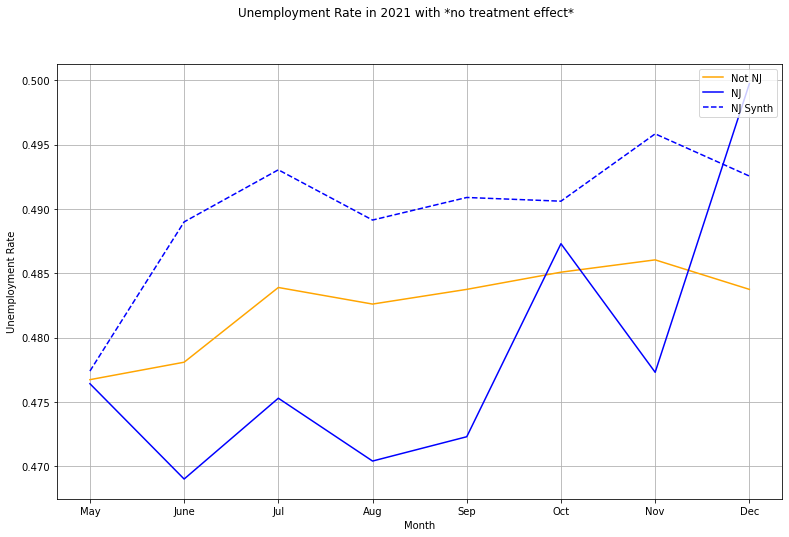

In [395]:

fig,ax = plt.subplots(figsize=(13,8))
df_plot = df.groupby(['treatment','date'])['laborforce_employed'].mean().to_frame()
df_plot.reset_index(inplace=True)
ax.plot( df_plot.loc[df_plot['treatment']==False]['date'], 
        df_plot.loc[df_plot['treatment']==False]['laborforce_employed'], 
            color='orange', label='Not NJ')
ax.plot( df_plot.loc[df_plot['treatment']==True]['date'], 
        df_plot.loc[df_plot['treatment']==True]['laborforce_employed'], 
        color='blue', label='NJ')
ax.plot( df_plot.loc[df_plot['treatment']==True]['date'], 
        df.loc[ df['treatment']==False].pivot(index='state', columns="date")['laborforce_employed'].T.dot(W_star), 
        color='blue', 
        linestyle='dashed',
        label='NJ Synth')

# ax.vlines(x=11, ymin=0, ymax = 0.05)

ax.set_ylabel('Unemployment Rate')
ax.set_xlabel('Month')
ax.set_xticks(np.arange(0,7.1,1))
ax.set_xticklabels(['May','June','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.grid()
ax.legend(loc='upper right')
fig.suptitle('Unemployment Rate in 2021 with *no treatment effect* ')
